In [187]:
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import eagle_tools
from os import makedirs, path
import shap
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from scipy.stats import spearmanr, binned_statistic
from statsmodels.nonparametric.smoothers_lowess import lowess
import time
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Use custom matplotlib template
plt.style.use('/users/arirrobe/MachineLearning/XGBoost_Remaster/mnras_mpl.stylesheet')

cosmology = FlatLambdaCDM(H0=67.74, Om0=0.3089)
 
# Define any required constants
omega_b = 0.0482519
omega_m = 0.307
Z_solar = 0.012663729
M_solar = 1.98841e33
Mpc = 3.086e24 
kpc = 3.086e21
pc = 3.086e18
eps_r = 0.1
eps_f = 0.15
c = 2.99792458e10
yr = 3.154e7
km = 1e5
G = 6.6743e-8

# Record starting time of code execution to track overall runtime
start_time = time.time()

In [188]:
# Import feedback energetics
with h5.File('/users/arirrobe/MachineLearning/XGBoost_Remaster/TNG100-1/Data/RECALIBRATED/TNG_100-1_NewFeedback.h5', 'r') as fi:
    e_agn_k = fi['E_AGN_K_INTERP'][()][:,::-1]
    e_agn_t = fi['E_AGN_T_INTERP'][()][:,::-1]
    e_sn = fi['E_SN_INTERP'][()][:,::-1]
    m_bh = fi['M_BH_INTERP'][()][:,::-1]
fi.close()

# Import centre of potential coordinates of haloes 
with h5.File('/users/arirrobe/MachineLearning/XGBoost_Remaster/TNG100-1/Data/TNG_100-1_SubhaloMPBs.h5', 'r') as fi:
    cop_x = fi['SubhaloPos'][()][:,:,0]
    cop_y = fi['SubhaloPos'][()][:,:,1]
    cop_z = fi['SubhaloPos'][()][:,:,2]
fi.close()

cop_x = np.delete(cop_x, [34,35,36,37,-1], axis=1)
cop_y = np.delete(cop_y, [34,35,36,37,-1], axis=1)
cop_z = np.delete(cop_z, [34,35,36,37,-1], axis=1)

cop_x = cop_x[:,::-1]
cop_y = cop_y[:,::-1]
cop_z = cop_z[:,::-1]

# Import cgm fraction of haloes
with h5.File('/users/arirrobe/MachineLearning/XGBoost_Remaster/TNG100-1/Data/TNG_100-1_f_CGM.h5', 'r') as fi:
    f_cgm = fi['f_CGM'][()][:,::-1]
fi.close()

# Import M200 of haloes
with h5.File('/users/arirrobe/MachineLearning/XGBoost_Remaster/TNG100-1/Data/TNG_100-1_MassHistory.h5', 'r') as fi:
    m200 = fi['M200_Progenitor'][()][:,::-1]
fi.close()

# Import specific SFR to define quiescence at z=0
with h5.File('/users/arirrobe/MachineLearning/XGBoost_Remaster/TNG100-1/Data/TNG_100-1_LinearProperties.h5', 'r') as fi:
    group_num_z0 = fi['GroupNumber'][()]
    ssfr_z0 = fi['sSFR'][()]
fi.close()

ssfr_z0 = ssfr_z0[np.argsort(group_num_z0)]
group_num_z0 = group_num_z0[np.argsort(group_num_z0)]

quenched_galaxies = np.zeros(len(ssfr_z0))
quenched_galaxies[ssfr_z0 < 1e-11] = 1  # Quenched if sSFR <= 1e-11
quenched_galaxies[ssfr_z0 >= 1e-11] = 0 # Star-forming if sSFR > 1e-11

# Cheap method for factoring out NaN values
e_agn_k[e_agn_k < 0] = 0
f_cgm[f_cgm < 0] = 0

# Combine input features into a 3D array of shape (N_galaxies, snapshots, N_features)
X = np.zeros((m200.shape[0], m200.shape[1], 9))
X[:,:,0] = m200
X[:,:,1] = e_agn_k
X[:,:,2] = e_agn_t 
X[:,:,3] = e_sn
X[:,:,4] = cop_x
X[:,:,5] = cop_y
X[:,:,6] = cop_z
X[:,:,7] = m_bh
X[:,:,8] = f_cgm

# Define target vector
y = quenched_galaxies

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Re-scale the data to be between -1 and 1 for use in LSTM
N, T, F = X_train.shape
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, F)).reshape(N, T, F)
X_test_scaled  = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape[0], T, F)

(4008, 95, 9) (1336, 95, 9)
(4008,) (1336,)


In [189]:
''' 
Create the LSTM class for predicting quiescence at z=0. LSTM init is defined by:
    input_dim -> Number of features
    hidden_dim -> Size of the hidden state in the LSTM (bigger = more complex)
    num_layers -> Number of layers in the LSTM (bigger = more complex)
    bidirectional -> Enables bidirectionality, where the model looks forwards and backwards through time (turn off for simpler models)
    
The LSTM takes the time-series of galaxy features in batches and processes them per timestep. 
The output is passed to the hidden layer(s), which in turn are then used as input into the attention mechanism.
The attention mechanism maps the output of the hidden layer to a scalar attention score, assigning weights
to the timesteps.
The context vector (weighted sum of LSTM outputs) is mapped to a scalar logit, 
which is passed through a sigmoid for binary classification. 

Whilst calculating attention scores, each timestep is scored using a learned linear layer.
The softmax function ensures all weights sum up to 1, allowing for interpretability in temporal importance.
The context vector is calculated as a weighted average of the LSTM outputs using the attention weights.
Predictions on galaxy quiescence are then made by mapping the context vector to a probability between 0 and 1 
which determines the class in which the batch belongs.
'''


class LSTMAttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False):
        super(LSTMAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_directions = 2 if bidirectional else 1

        # Initialise the LSTM model
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Initialise the attention mechanism and output layer
        self.attn = nn.Linear(hidden_dim * self.num_directions, 1)
        self.output_layer = nn.Linear(hidden_dim * self.num_directions, 1)

    # Construct the forward pass routine for the LSTM
    def forward(self, x):   # x: (batch_size, time_steps, input_dim)
        lstm_out, _ = self.lstm(x)  # (batch_size, time_steps, hidden_dim)
        attn_scores = self.attn(lstm_out)  # (batch_size, time_steps, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # softmax over time
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (batch_size, hidden_dim)
        output = torch.sigmoid(self.output_layer(context))  # binary classification
        return output, attn_weights.squeeze(-1)

In [210]:
# Initialise input parameters for LSTM
input_dim = X_train.shape[2]     # Feature Dimension
timesteps = X_train.shape[1]     # Time Dimension
hidden_dim = 32
epochs = 100
batch_size = 64
lr = 1e-4

# Model, loss, optimizer
model = LSTMAttentionClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=1, bidirectional=False)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check availability of GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


'''
The training loop runs for a predetermined number of epochs, with each epoch being a full shuffled pass through the training set.
Each shuffled training set is different for each epoch.
The mini-batch loop iterates through the training data in chunks equivalent to batch_size. The mini batches themselves are
selected using the shuffled indices from torch.randperm.
For each batch, the following processes happen:
    - The forward pass gets the model predictions
    - Binary cross-entropy is used as the loss metric
    - Backpropagation then computes the gradients
    - Optimiser is then used to update the model weights (updates model parameters to represent learned information)
    
We then switch the model to evaluation mode using model.eval(). This disables dropout and batch norm, and also disables
gradient tracking.
Predictions are made on the test set and accuracy metrics are calculated based on the model's performance. 
The attention weights are then retrieved from the model and saved for each epoch. This allows for the average weighting
to be given per timestep across all epochs.
For most of our analysis, the weights will be taken from the best-performing or final epoch.
'''


# Training loop
for epoch in range(epochs):
    model.train() # Ensure model is in training mode (would enable dropout if applicable)
    perm = torch.randperm(X_train_tensor.size(0)) # Randomly shuffles training data and retrieves their indices

    for i in range(0, X_train_tensor.size(0), batch_size):
        idx = perm[i:i+batch_size]
        x_batch = X_train_tensor[idx]
        y_batch = y_train_tensor[idx].view(-1, 1)

        optimizer.zero_grad()
        preds, _ = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_preds, test_attn = model(X_test_tensor)
        test_preds_np = test_preds.cpu().numpy().flatten()
        test_labels_np = y_test_tensor.cpu().numpy().flatten()

        pred_binary = (test_preds_np >= 0.5).astype(int)
        acc = accuracy_score(test_labels_np, pred_binary)
        auc = roc_auc_score(test_labels_np, test_preds_np)
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Acc = {acc:.3f}, AUC = {auc:.3f}")
        
    # Initialize list once
    if epoch == 0:
        attn_history_all = []

    # Save global attention per epoch
    attn_weights_np = test_attn.cpu().numpy()  # (batch_size, timesteps)
    mean_attn_per_timestep = attn_weights_np.mean(axis=0)  # (timesteps,)
    attn_history_all.append(mean_attn_per_timestep.copy())
    
attn_history_all = np.array(attn_history_all)

Epoch 1: Loss = 0.6622, Acc = 0.752, AUC = 0.603
Epoch 2: Loss = 0.6376, Acc = 0.752, AUC = 0.774
Epoch 3: Loss = 0.5703, Acc = 0.752, AUC = 0.878
Epoch 4: Loss = 0.4375, Acc = 0.752, AUC = 0.938
Epoch 5: Loss = 0.3988, Acc = 0.752, AUC = 0.947
Epoch 6: Loss = 0.4137, Acc = 0.753, AUC = 0.951
Epoch 7: Loss = 0.3947, Acc = 0.756, AUC = 0.946
Epoch 8: Loss = 0.4406, Acc = 0.777, AUC = 0.942
Epoch 9: Loss = 0.3385, Acc = 0.811, AUC = 0.937
Epoch 10: Loss = 0.3955, Acc = 0.838, AUC = 0.934
Epoch 11: Loss = 0.2599, Acc = 0.850, AUC = 0.936
Epoch 12: Loss = 0.2679, Acc = 0.853, AUC = 0.937
Epoch 13: Loss = 0.2735, Acc = 0.860, AUC = 0.937
Epoch 14: Loss = 0.3689, Acc = 0.862, AUC = 0.939
Epoch 15: Loss = 0.2775, Acc = 0.865, AUC = 0.940
Epoch 16: Loss = 0.2461, Acc = 0.865, AUC = 0.942
Epoch 17: Loss = 0.3410, Acc = 0.862, AUC = 0.945
Epoch 18: Loss = 0.2375, Acc = 0.870, AUC = 0.944
Epoch 19: Loss = 0.2295, Acc = 0.868, AUC = 0.945
Epoch 20: Loss = 0.2456, Acc = 0.873, AUC = 0.944
Epoch 21:

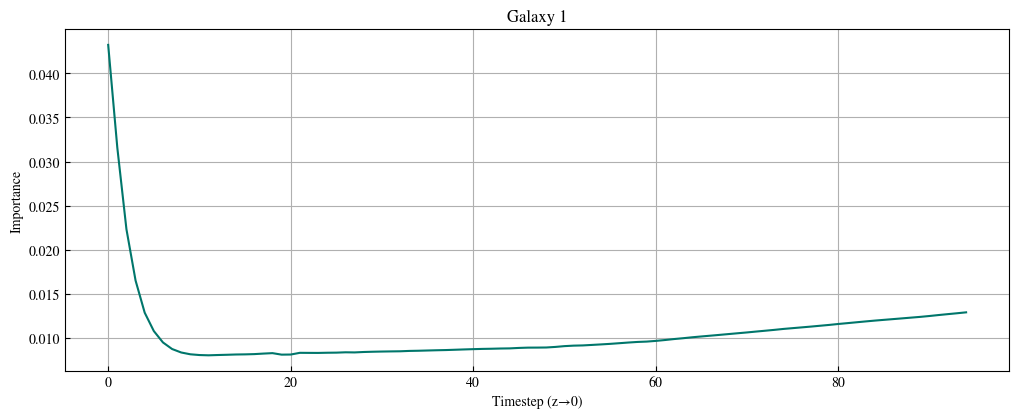

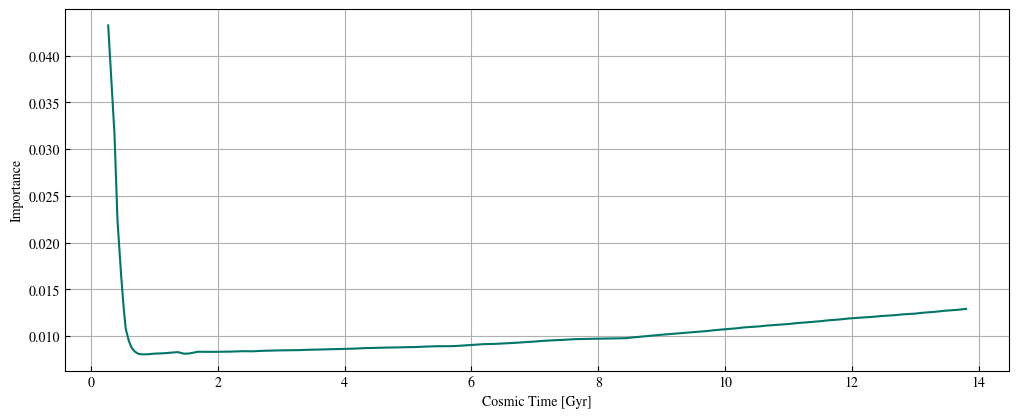

In [211]:
with h5.File('/users/arirrobe/MachineLearning/XGBoost_Remaster/TNG100-1/Data/TNG_100-1_SubhaloMPBs.h5', 'r') as fi:
    redshifts = fi['/Redshift'][()]
fi.close()
redshifts = np.delete(redshifts, [34,35,36,37,-1])
cosmic_time = cosmology.age(redshifts).value
cosmic_time = cosmic_time[::-1]

sample_idx = 1
attn_sample = test_attn[sample_idx].cpu().numpy()

plt.figure(figsize=(10, 4))
plt.plot(range(timesteps), attn_sample)
plt.title(f"Galaxy 1")
plt.xlabel("Timestep (z→0)")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(cosmic_time, attn_sample)
ax.set_xlabel("Cosmic Time [Gyr]")
ax.set_ylabel('Importance')
ax.grid(True)
plt.show()

Epoch 100: Mean Attention (first 10 timesteps): [0.02920408 0.02132355 0.01552169 0.01174117 0.00942825 0.00803345
 0.00720525 0.00671481 0.00641795 0.00624123]


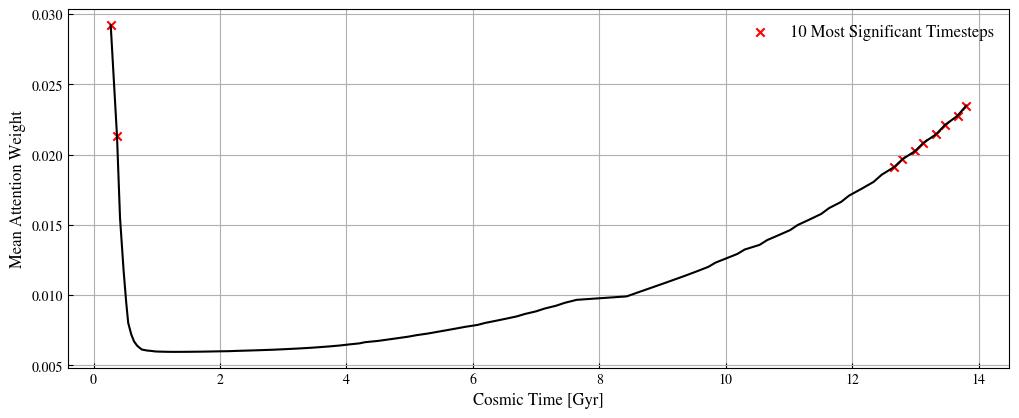

In [212]:
# Average attention per timestep (global importance)
attn_weights_np = test_attn.cpu().numpy()  # shape: (batch_size, cosmic_time)
mean_attn_per_timestep = attn_weights_np.mean(axis=0)  # shape: (cosmic_time,)

print(f"Epoch {epoch+1}: Mean Attention (first 10 timesteps): {mean_attn_per_timestep[:10]}")

most_significant_idx = np.argsort(mean_attn_per_timestep)[-10:]

fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(cosmic_time, mean_attn_per_timestep, c='k')
ax.scatter(cosmic_time[most_significant_idx], mean_attn_per_timestep[most_significant_idx], c='r', marker='x', label='10 Most Significant Timesteps')
ax.set_xlabel('Cosmic Time [Gyr]', fontsize=12)
ax.set_ylabel('Mean Attention Weight', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.show()

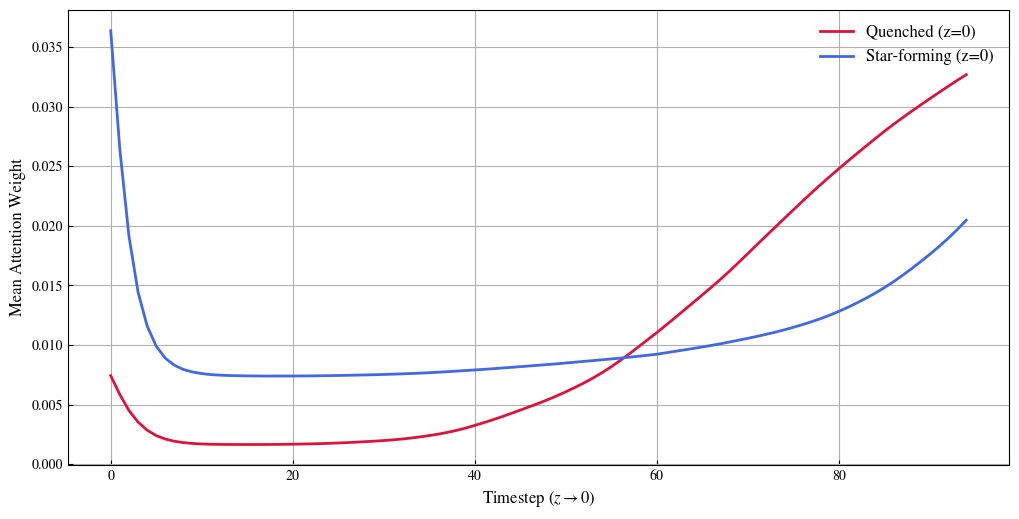

In [213]:
# Get attention and labels for test set at final epoch
test_attn_np = test_attn.cpu().numpy()        # shape: (N_test, T)
test_labels_np = y_test_tensor.cpu().numpy()  # shape: (N_test,)

# Split attention by class
attn_quenched = test_attn_np[test_labels_np == 1] 
attn_starform = test_attn_np[test_labels_np == 0]

# Take the average attention weighting per timestep
mean_quenched = attn_quenched.mean(axis=0)
mean_starform = attn_starform.mean(axis=0)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(mean_quenched, lw=2, c='crimson', label="Quenched (z=0)")
ax.plot(mean_starform, lw=2, c='royalblue', label="Star-forming (z=0)")
ax.set_xlabel("Timestep ($z \\rightarrow 0$)", fontsize=12)
ax.set_ylabel("Mean Attention Weight", fontsize=12)
ax.legend(fontsize=12)
ax.grid(visible=True)
plt.show()

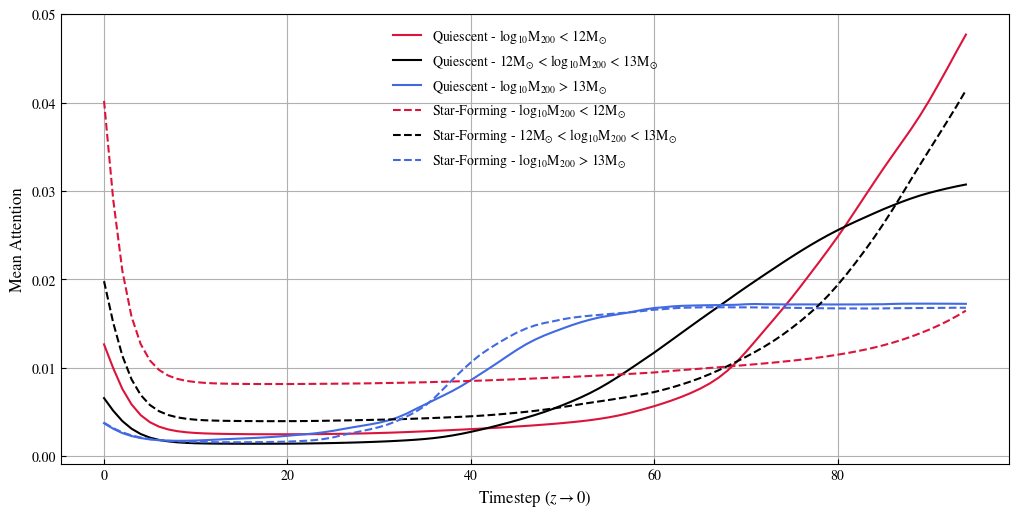

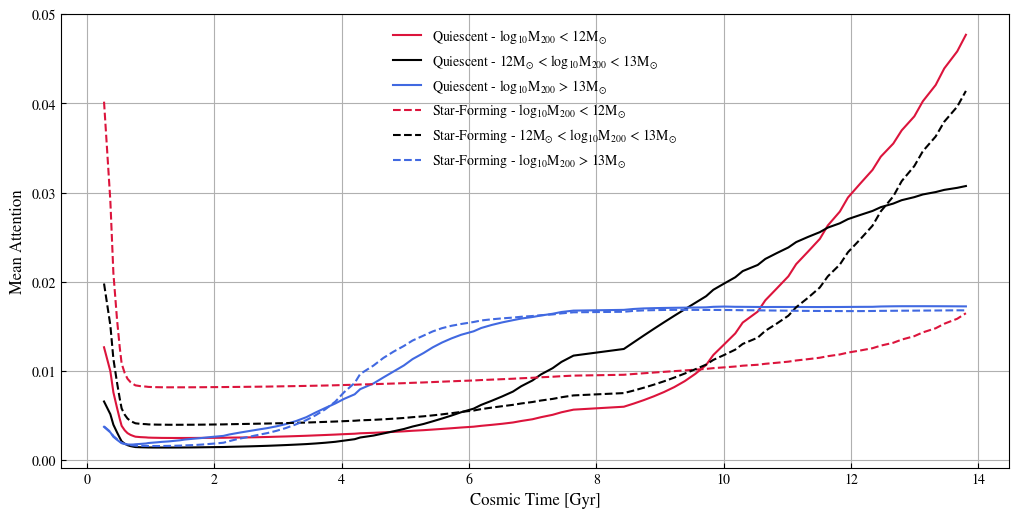

In [214]:
# Get final M200 for test galaxies (shape: N_test)
m200_test = X_test[:, -1, 0]
log_m200_test = np.log10(m200_test + 1e-10)

# Mask for low, intermediate and high masses, as well as quiescent vs star-forming
low_mask = log_m200_test < 12
med_mask = (log_m200_test >= 12) & (log_m200_test < 13)
high_mask = log_m200_test >= 13

quiescent_mask = test_labels_np == 1  # quenched = label 1
starforming_mask = test_labels_np == 0


attn_low_quiescent = test_attn_np[low_mask & quiescent_mask]
attn_low_starforming = test_attn_np[low_mask & starforming_mask]
attn_med_quiescent = test_attn_np[med_mask & quiescent_mask]
attn_med_starforming = test_attn_np[med_mask & starforming_mask]
attn_high_quiescent = test_attn_np[high_mask & quiescent_mask]
attn_high_starforming = test_attn_np[high_mask & starforming_mask]

mean_low_quiescent = attn_low_quiescent.mean(axis=0)
mean_low_starforming = attn_low_starforming.mean(axis=0)
mean_med_quiescent = attn_med_quiescent.mean(axis=0)
mean_med_starforming = attn_med_starforming.mean(axis=0)
mean_high_quiescent = attn_high_quiescent.mean(axis=0)
mean_high_starforming = attn_high_starforming.mean(axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(mean_low_quiescent, label='Quiescent - $\\rm log_{10} \\rm M_{200}$ < $12\\rm M_{\\odot}$', color='crimson')
ax.plot(mean_med_quiescent, label='Quiescent - $12\\rm M_{\\odot}$ < $\\rm log_{10} \\rm M_{200}$ < $13\\rm M_{\\odot}$', color='k')
ax.plot(mean_high_quiescent, label='Quiescent - $\\rm log_{10} \\rm M_{200}$ > $13\\rm M_{\\odot}$', color='royalblue')
ax.plot(mean_low_starforming, ls='--', label='Star-Forming - $\\rm log_{10} \\rm M_{200}$ < $12\\rm M_{\\odot}$', color='crimson')
ax.plot(mean_med_starforming, ls='--', label='Star-Forming - $12\\rm M_{\\odot}$ < $\\rm log_{10} \\rm M_{200}$ < $13\\rm M_{\\odot}$', color='k')
ax.plot(mean_high_starforming, ls='--', label='Star-Forming - $\\rm log_{10} \\rm M_{200}$ > $13\\rm M_{\\odot}$', color='royalblue')
ax.set_xlabel('Timestep ($z \\rightarrow 0$)', fontsize=12)
ax.set_ylabel('Mean Attention', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(cosmic_time, mean_low_quiescent, label='Quiescent - $\\rm log_{10} \\rm M_{200}$ < $12\\rm M_{\\odot}$', color='crimson')
ax.plot(cosmic_time, mean_med_quiescent, label='Quiescent - $12\\rm M_{\\odot}$ < $\\rm log_{10} \\rm M_{200}$ < $13\\rm M_{\\odot}$', color='k')
ax.plot(cosmic_time, mean_high_quiescent, label='Quiescent - $\\rm log_{10} \\rm M_{200}$ > $13\\rm M_{\\odot}$', color='royalblue')
ax.plot(cosmic_time, mean_low_starforming, ls='--', label='Star-Forming - $\\rm log_{10} \\rm M_{200}$ < $12\\rm M_{\\odot}$', color='crimson')
ax.plot(cosmic_time, mean_med_starforming, ls='--', label='Star-Forming - $12\\rm M_{\\odot}$ < $\\rm log_{10} \\rm M_{200}$ < $13\\rm M_{\\odot}$', color='k')
ax.plot(cosmic_time, mean_high_starforming, ls='--', label='Star-Forming - $\\rm log_{10} \\rm M_{200}$ > $13\\rm M_{\\odot}$', color='royalblue')
ax.set_xlabel('Cosmic Time [Gyr]', fontsize=12)
ax.set_ylabel('Mean Attention', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)
plt.show()

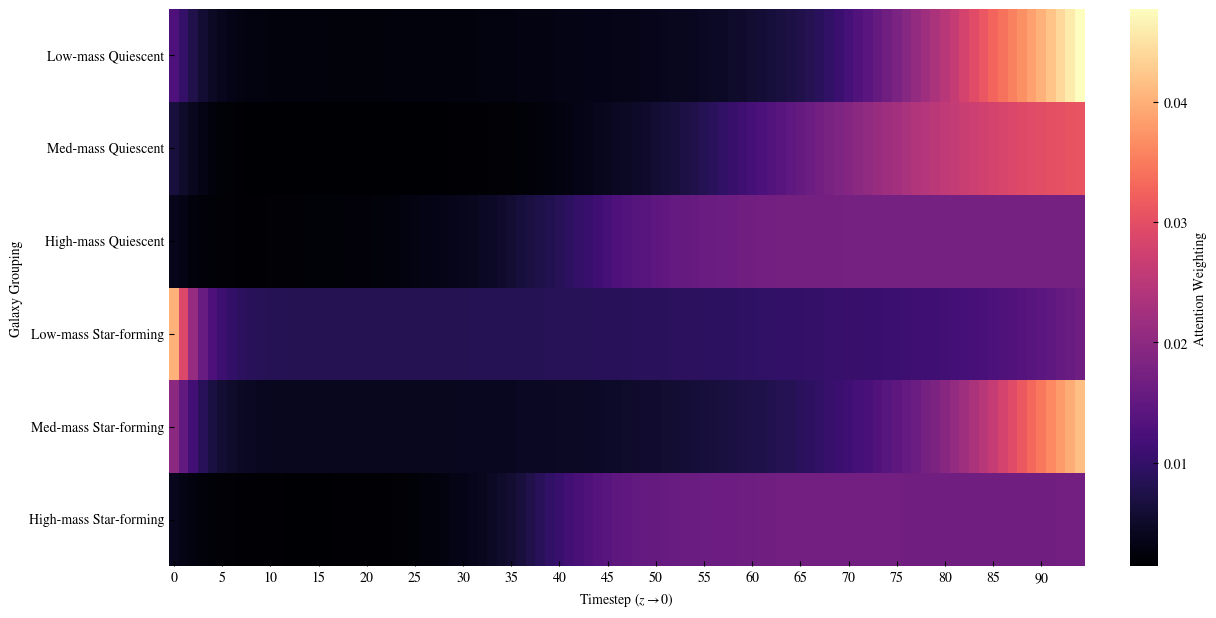

In [215]:
heat_data = np.stack([
    mean_low_quiescent,
    mean_med_quiescent,
    mean_high_quiescent,
    mean_low_starforming,
    mean_med_starforming,
    mean_high_starforming
], axis=0)

group_labels = [
    "Low-mass Quiescent",
    "Med-mass Quiescent",
    "High-mass Quiescent",
    "Low-mass Star-forming",
    "Med-mass Star-forming",
    "High-mass Star-forming"
]

plt.figure(figsize=(12, 6), constrained_layout=True)
sns.heatmap(heat_data, annot=False, cmap="magma", xticklabels=5, yticklabels=group_labels, cbar_kws={'label': 'Attention Weighting'})
plt.xlabel('Timestep ($z \\rightarrow 0$)')
plt.ylabel('Galaxy Grouping')
plt.show()

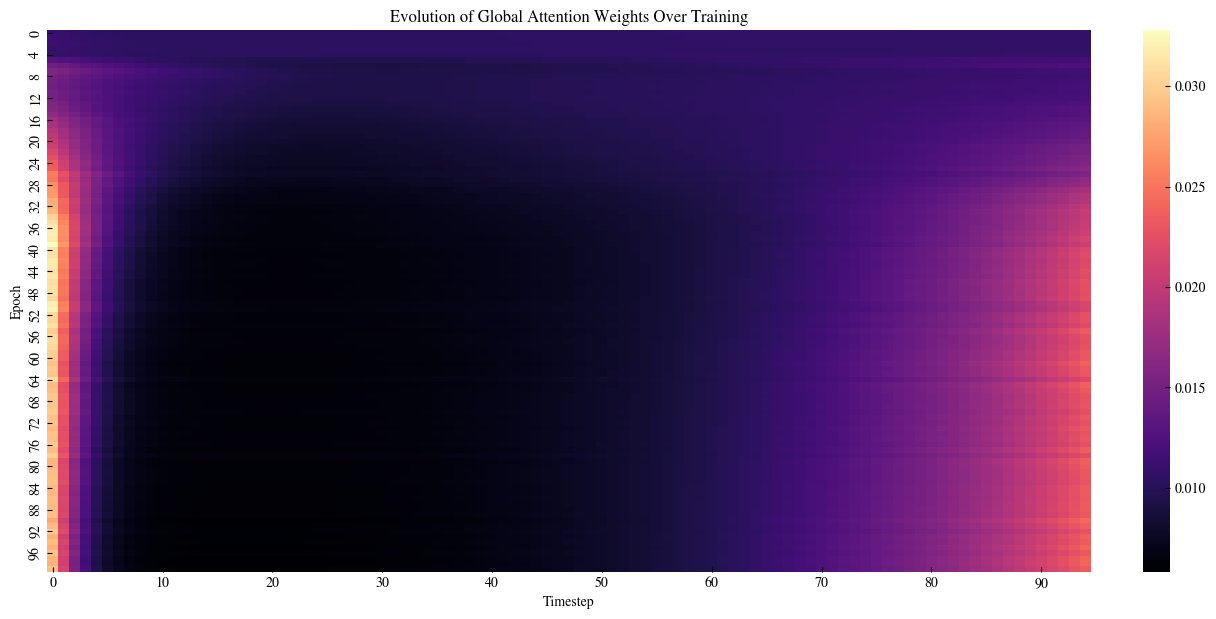

In [216]:
plt.figure(figsize=(12, 6))
sns.heatmap(attn_history_all, cmap='magma', xticklabels=10)
plt.xlabel("Timestep")
plt.ylabel("Epoch")
plt.title("Evolution of Global Attention Weights Over Training")
plt.show()

Selected SHAP group shape: (1005, 95, 9)


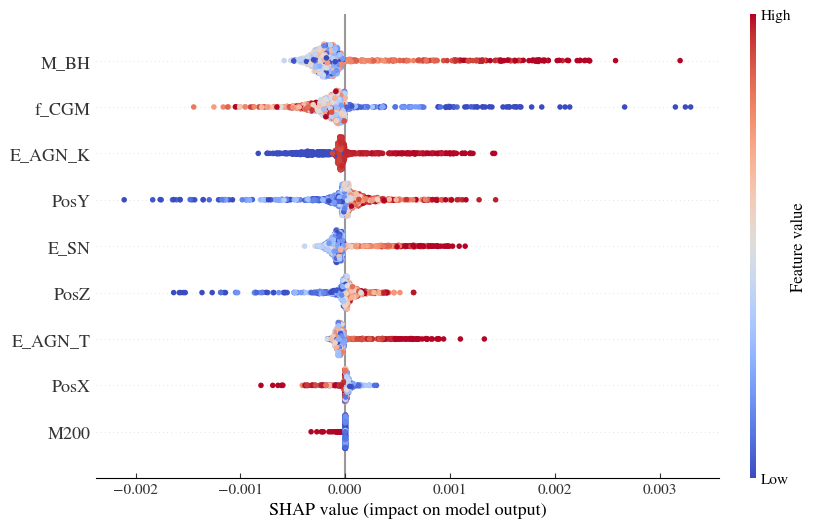

In [217]:
class LSTMWrappedForSHAP(nn.Module):
    def __init__(self, model, time_steps, feature_dim):
        super().__init__()
        self.model = model
        self.T = time_steps
        self.F = feature_dim

    def forward(self, x_flat):
        # Reshape (batch_size, T*F) → (batch_size, T, F)
        x_seq = x_flat.view(-1, self.T, self.F)
        out, _ = self.model(x_seq)
        return out


X_selected = X_test_scaled[starforming_mask]
print(f"Selected SHAP group shape: {X_selected.shape}")  # (N_selected, 95, 9)

# Flatten time and feature dimensions
X_selected_flat = X_selected.reshape(X_selected.shape[0], -1)

# Convert model to eval mode
model.eval()

# Wrap the model
shap_model = LSTMWrappedForSHAP(model, time_steps=X_selected.shape[1], feature_dim=X_selected.shape[2]).to(device)

# Create SHAP explainer
background = torch.tensor(X_selected_flat[:100], dtype=torch.float32).to(device)  # sample for speed

timestep = 90
feature_names = ['M200', 'E_AGN_K', 'E_AGN_T', 'E_SN', 'PosX', 'PosY', 'PosZ', 'M_BH', 'f_CGM']

explainer = shap.GradientExplainer(shap_model, background)
shap_values = explainer(torch.tensor(X_selected_flat, dtype=torch.float32).to(device))
shap_values.feature_names = feature_names

n_features = X_selected.shape[2]
start_idx = timestep * n_features
end_idx = (timestep + 1) * n_features

# Subset Explanation object to only timestep 90
shap_values_t = shap_values[:, start_idx:end_idx]

fig = plt.subplots(figsize=(8,8))
shap.plots.beeswarm(shap_values_t, max_display=9, show=True, color=plt.get_cmap("coolwarm"))

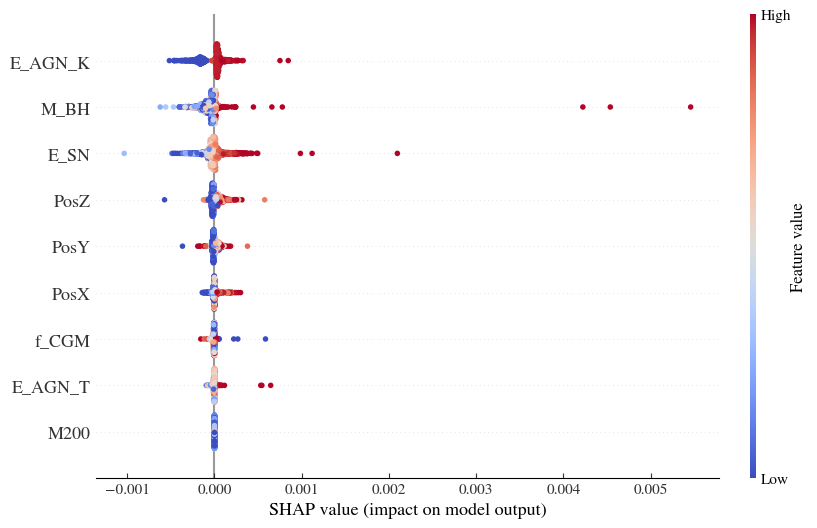

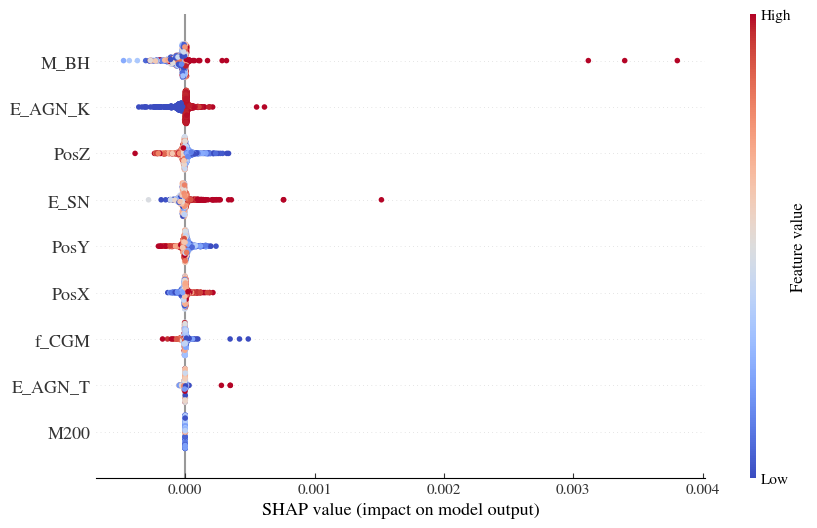

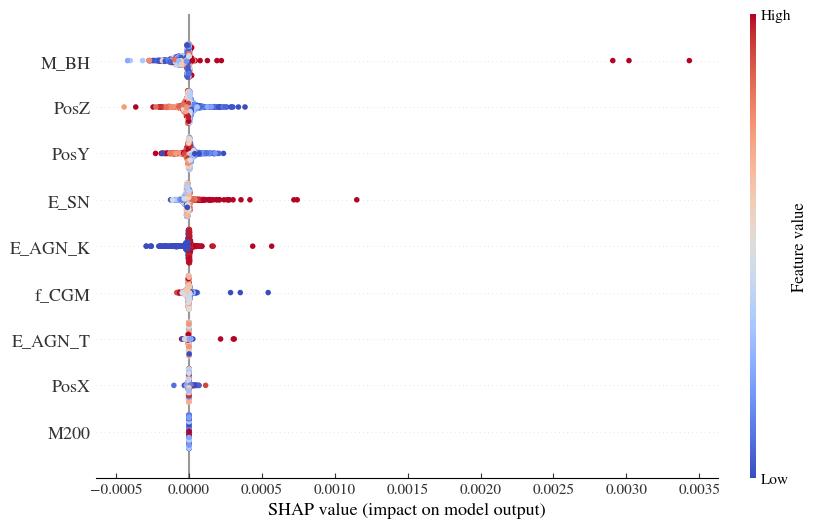

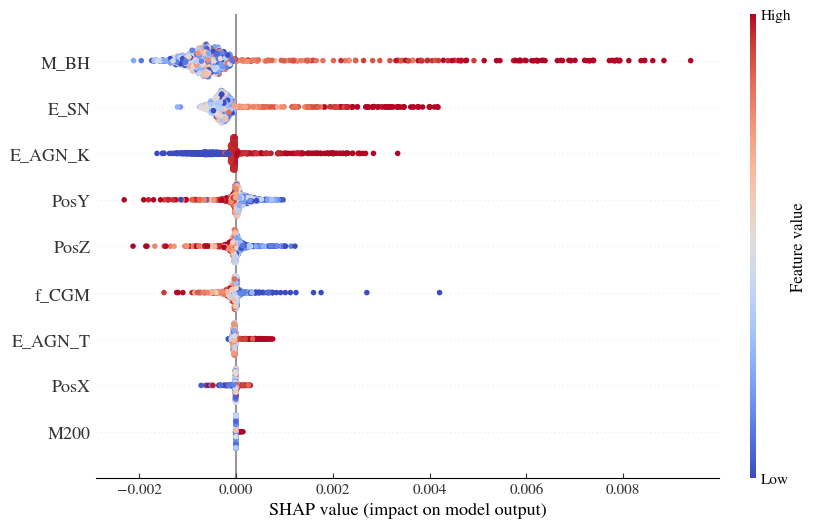

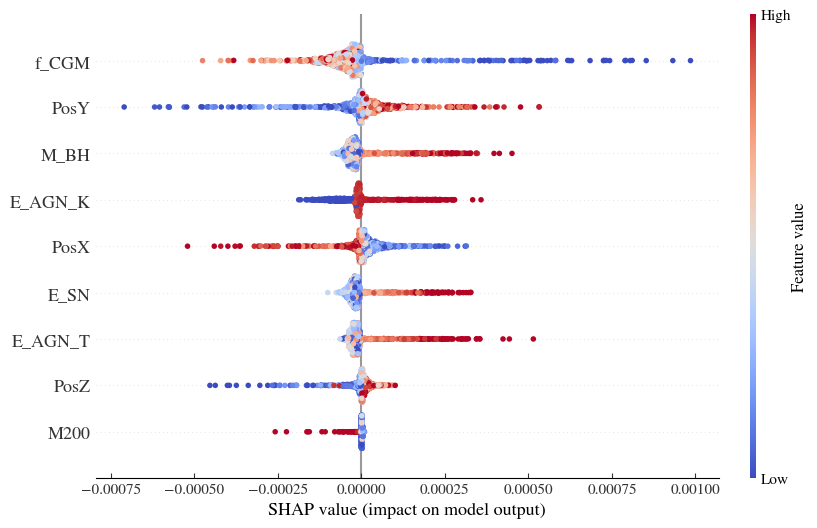

In [218]:
timestep = 1
n_features = X_selected.shape[2]
start_idx = timestep * n_features
end_idx = (timestep + 1) * n_features

# Subset Explanation object to only timestep 90
shap_values_t = shap_values[:, start_idx:end_idx]

fig = plt.subplots(figsize=(8,8))
shap.plots.beeswarm(shap_values_t, max_display=9, show=True, color=plt.get_cmap("coolwarm"))


timestep = 5
n_features = X_selected.shape[2]
start_idx = timestep * n_features
end_idx = (timestep + 1) * n_features

# Subset Explanation object to only timestep 90
shap_values_t = shap_values[:, start_idx:end_idx]

fig = plt.subplots(figsize=(8,8))
shap.plots.beeswarm(shap_values_t, max_display=9, show=True, color=plt.get_cmap("coolwarm"))


timestep = 10
n_features = X_selected.shape[2]
start_idx = timestep * n_features
end_idx = (timestep + 1) * n_features

# Subset Explanation object to only timestep 90
shap_values_t = shap_values[:, start_idx:end_idx]

fig = plt.subplots(figsize=(8,8))
shap.plots.beeswarm(shap_values_t, max_display=9, show=True, color=plt.get_cmap("coolwarm"))


timestep = 50
n_features = X_selected.shape[2]
start_idx = timestep * n_features
end_idx = (timestep + 1) * n_features

# Subset Explanation object to only timestep 90
shap_values_t = shap_values[:, start_idx:end_idx]

fig = plt.subplots(figsize=(8,8))
shap.plots.beeswarm(shap_values_t, max_display=9, show=True, color=plt.get_cmap("coolwarm"))


timestep = 94
n_features = X_selected.shape[2]
start_idx = timestep * n_features
end_idx = (timestep + 1) * n_features

# Subset Explanation object to only timestep 90
shap_values_t = shap_values[:, start_idx:end_idx]

fig = plt.subplots(figsize=(8,8))
shap.plots.beeswarm(shap_values_t, max_display=9, show=True, color=plt.get_cmap("coolwarm"))